In [1]:
#.............................................
# IMPORT STATEMENTS
#.............................................

# local env is py310

#General Python math functions
import math
#Loading in data (netcdf files)
import h5py
#Handling data
import numpy as np
import netCDF4 as nc
#Plotting figures
import matplotlib.pyplot as plt #Main plotting package
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker

#machine learning package
import tensorflow as tf
print(tf.__version__)

2.16.2


### **getting data**

In [2]:
import os

# change to specific directory for user running code 
os.chdir("/Users/sophiekim/Desktop/2_research/MamalakisResearch") 
base_path = os.getcwd()

# everyone should have locally loaded 'data' folder
data_path = base_path + '/data/'

In [3]:
# initializing model list variable to call in function
model_list = [
    "CNRM_ESM2-1_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MIROC6_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MPI-ESM1-2-LR_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MRI-ESM2-0_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "UKESM1-0-LL_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
]

#### **converting units**

In [4]:
def convert_units(varname: str, x: np.ndarray):
    """
    varname: index number from the list of variables so get_data func can convert units 
    x: data that needs units changed (raw x data) in get_data func 
    """
    if varname in {"tas", "tasmax", "tasmin"}:
        # kelvin to celcius
        return x - 273.15, "$^{\circ}$C"
    if varname == "pr":
        # kg/m2/s to mm/day
        return x * 86400.0, "mm/day"
    if varname == "psl":
        # pascals to hpa
        return x / 100.0, "hPa"
    
    # these don't need to be converted -- just adding the units 
    if varname == "sfcWind":
        return x, "m/s"
    if varname == "mrsos":
        return x, "kg/m$^{2}$"
    return x, "unknown"

#### **prepping tensors**

In [5]:
def get_model_name(path: str) -> str:
    """
    helper function so that get_cnn_tensors prints out the models that are being processed
    pulled from hayeon's code 
    """
    # Everything before "_ssp..."
    return os.path.basename(path).split("_ssp")[0]

In [6]:
def get_cnn_tensors(model_list, scenario, data_path, var_idx, 
                    st_early=2015, end_early=2024, 
                    st_late=2050, end_late=2059,
                    stat='mean', use_anomaly=True, 
                    base_start=2015, base_end=2024,
                    models_to_run=None, file_start_year=2015):
    """
    model_list: variable of list of models
    scenario: input as either 'ssp119' or 'ssp126' strings
    data_path: variable of data_path for user
    var_idx: 0-6 of the variable dimension of tensor 
        0: tas (near-surface air temp)
        1: tasmax (near-surface air temp max)
        2: tasmin (near-surface air temp min)
        3: pr (precipitation)
        4: psl (sea level pressure -- air pressure adjusted to sea level & drives weather patterns)
        5: sfcWind (surface wind speed -- usually 10m above land surface)
        6: mrsos (moisture in upper portion of soil col -- good for looking at agr & drought conditions)
    st_early: early period start yr integer
    end_early: early period end yr integer
    st_late: late period start yr integer
    end_late: late period end yr integer
    stat: what stat function user wants to run to summarize variables 
        mean: mean
        std: standard deviation
        max: max val
        min: min val
        medium: median
    use_anomaly: whether to subtract values from baseline values to find anomaly
        True: subtract values
        False: don't subtract values 
    base_start: baseline yr start
    base_end: baseline yr end 
    models_to_run: can specify number of models to run by index of model_list variable
        None: all models 
        [x]: one model to run 
        [x, x, x...]: whatever number of models to run 
    file_start_year: ensuring that if time dimension in models starts at 0 or 1, the func will slice the time correctly 
    """
    
    # indices in variable dimension to variable names 
    var_list = ["tas", "tasmax", "tasmin", "pr", "psl", "sfcWind", "mrsos"]
    # checking var_list for the specific variable index and if the var_idx input is bigger than 6, will give unknown 
    varname = var_list[var_idx] if var_idx < len(var_list) else "unknown"

    # making stat dictionary so stat input in func will do correct specified math 
    stat_map = {
        'mean': np.nanmean, 'std': np.nanstd, 
        'max': np.nanmax, 'min': np.nanmin, 'median': np.nanmedian
    }
    # variable that will calculate the stat for whatever the user wants and then will default to mean 
    calc_func = stat_map.get(stat.lower(), np.nanmean)

    # runs all models 
    if models_to_run is None:
        selected_models = model_list
    # runs one model if user only specified one 
    elif isinstance(models_to_run, int):
        selected_models = [model_list[models_to_run]]
    # if none of the above options (all or one) was selected, then was list of models so get those models 
    else:
        selected_models = [model_list[i] for i in models_to_run]

    # intilaizing x & y lists 
    x_list, y_list = [], []
    # if in early period, then 0; if in late period, then 1 
    periods = [(st_early, end_early, 0), (st_late, end_late, 1)]

    print(f"Variable: {varname} | Stat: {stat} | Anomaly: {use_anomaly}")

    # opening file 
    for filename in selected_models:
        full_path = os.path.join(data_path, filename)
        model_short_name = get_model_name(filename)
        print(f"Processing Model: {model_short_name}")
        with nc.Dataset(full_path) as ds:
            # slicing data from models to get specific ssp scenario and for that variable 
                # so dimensions should be [ensemble, time, lat, lon]
            data_raw = ds[f"data_{scenario}"][:, var_idx, :, :, :]
            
            # calling convert_units func
            data, unit_str = convert_units(varname, data_raw)
            # Check the time metadata
            time_var = ds.variables['time']
            print(f"Time units in file: {time_var.units}")

            # Check the first time value
            first_month_val = time_var[0]
            print(f"First time index value: {first_month_val}")
            # if use_anomaly is true 
            if use_anomaly:
                # calculate start & end month index for baseline period 
                b_start, b_end = (base_start-file_start_year)*12, (base_end-file_start_year+1)*12
                # base variable values calculated for baseline period 
                ensemble_base = calc_func(data[:, b_start:b_end, :, :], axis=1)

            # looping through both early & late periods from the periods var 
            for start_yr, end_yr, label in periods:
                # looping thru each yr in the period 
                for yr_idx in range(start_yr, end_yr + 1):
                    
                    # getting month index values for a yr 
                    m_start = (yr_idx - file_start_year) * 12
                    m_end = m_start + 12
                    
                    # going thru each trajectory in model file
                    for ens_idx in range(5):
                        # slicing to isolate one trajectory for a yr and all lats/lons
                        annual_slice = data[ens_idx, m_start:m_end, :, :]
                        # calculating the values from stat input from user for every yr 
                        yearly_val = calc_func(annual_slice, axis=0)
                        
                        # if the use_anaomaly is true, then u subtract the yearly values from the baseline
                            # if use_anomaly is false, then val = yearly_val 
                        val = yearly_val - ensemble_base[ens_idx] if use_anomaly else yearly_val
                        
                        # adding vals to the x_list and the 0/1 for y_list 
                        x_list.append(val)
                        y_list.append(label)

    # adding everything all together 
        # np.expand_dims to make another dimension for the calculated values 
    x_data = np.expand_dims(np.array(x_list), axis=1) 
    # adding the 0/1 values and reshaping for a 500,1 shape 
    y_data = np.array(y_list).reshape(-1, 1)
    
    # replacing the NAs to 0s in x_data 
    return np.nan_to_num(x_data, nan=0.0), y_data

### **running data prep**

In [7]:
x_data, y_data = get_cnn_tensors(model_list, scenario='ssp126', data_path=data_path, var_idx=0)

Variable: tas | Stat: mean | Anomaly: True
Processing Model: CNRM_ESM2-1
Time units in file: months
First time index value: 1.0
Processing Model: MIROC6


/var/folders/v1/c8q_17915_v735dr_k_2fb7w0000gn/T/ipykernel_29910/3189251569.py:95: RuntimeWarning: Mean of empty slice
  ensemble_base = calc_func(data[:, b_start:b_end, :, :], axis=1)
/var/folders/v1/c8q_17915_v735dr_k_2fb7w0000gn/T/ipykernel_29910/3189251569.py:111: RuntimeWarning: Mean of empty slice
  yearly_val = calc_func(annual_slice, axis=0)


Time units in file: months
First time index value: 1.0
Processing Model: MPI-ESM1-2-LR
Time units in file: months
First time index value: 1.0
Processing Model: MRI-ESM2-0
Time units in file: months
First time index value: 1.0
Processing Model: UKESM1-0-LL
Time units in file: months
First time index value: 1.0


### **TRAIN TEST SPLIT**

In [8]:
from sklearn.model_selection import train_test_split

# Step 1: Separate the Test set (50 samples out of 500 = 10%)
# This leaves 450 samples for (Train + Validation)
X_temp, X_test, y_temp, y_test = train_test_split(
    x_data, y_data, test_size=50, random_state=42
)

# Step 2: Separate Validation from the remaining 450 samples
# To get exactly 50 samples from 450, the ratio is 50/450 (approx 0.111)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=50, random_state=42
)

print(f"Train size: {len(X_train)}")      # 400
print(f"Validation size: {len(X_val)}")    # 50
print(f"Test size: {len(X_test)}")        # 50

Train size: 400
Validation size: 50
Test size: 50


In [9]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_val shape: {y_val.shape}")

X_train shape: (400, 1, 144, 73)
Y_train shape: (400, 1)
X_val shape: (50, 1, 144, 73)
Y_val shape: (50, 1)


### **CREATING CNN**

In [ ]:
from tensorflow.keras import layers, models

def create_cnn(input_shape):
    # creating sequential model so that output of layer 1 becomes input for layer 2, etc. 
    model = models.Sequential([
        # LAYER 1: 
            # 3x3 kernels
            # same padding (puts zeroes on the outsides so that output shape same as input)
            # data_format channels_first means that the channel (aka the sample) is first, then the long/lat stuff
        layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', 
                      input_shape=input_shape, data_format='channels_first'),
            
        # LAYER 1.5
            # maxpooling --> looking at 2x2 blocks and taking max 
        layers.MaxPooling2D((2, 2), data_format='channels_first'),
        
        # LAYER 2: 
            # same thing as above 
        layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', 
                      data_format='channels_first'),
        layers.MaxPooling2D((2, 2), data_format='channels_first'),
        
        # LAYER 3: 
            # same thing as above
        layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', 
                      data_format='channels_first'),
        layers.MaxPooling2D((2, 2), data_format='channels_first'),

        # LAYER 4: 
         layers.Conv2D(16, (3, 3), strides=1, padding='same', activation='relu', 
                      data_format='channels_first'),
        layers.MaxPooling2D((2, 2), data_format='channels_first'),
        
        # using dropout to ensure model does not overfit / rely on single feature to make predictions 
            # turns off 30% of neurons during each training step 
        layers.Dropout(0.3), 
        
        # taking the 2d map (aka the long/lat) to a long 1d vector of numbers
        layers.Flatten(), 
        
        # FULLY CONNECTED LAYERS 
            # taking patterns found in convolutions and weighing against each other to see if they look like future climate
        layers.Dense(50, activation='relu'), 
            # refines decision making 
        layers.Dense(10, activation='relu'),
        
        # OUTPUT LAYER
            # one neuron 
            # sigmoid bc output should be between 0-1 
                # closer to 0 --> early period 
                # closer to 1 --> late period 
        layers.Dense(1, activation='sigmoid') 
    ])
    
    return model

In [53]:
# getting one sample from the 400 batch in x train 
    # and then model will go through everything 400 times for each sample in the batch 
input_dims = X_train.shape[1:] 

# building model 
model = create_cnn(input_dims)

# getting architecture and param summary for every step 
model.summary()

/Users/sophiekim/miniforge3/envs/climate_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 64, 144, 73)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 72, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 72, 36)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 64, 36, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 36, 18)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 32, 18, 9)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 18, 9)      │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 9, 4)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 9, 4)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 50)             │        28,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,027 (351.67 KB)

 Trainable params: 90,027 (351.67 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def train_cnn(x_train, y_train, x_val, y_val):
    # building CNN architecutre using func above 
    model = create_cnn(x_train.shape[1:])
    
    # optimizing model with adam & leanring rate 
        # adam computes individual adaptive learning rates for every individual weight in CNN
        # using binary cross entropy since  predicting late/early periods 
        # outputting model accuracy 
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # early stopping 
        # val_loss for tracking validation loss 
        # if val_loss doesn't get better after 5 epochs, will stop 
        # restore_best_weights ensures that model goes back to epoch that had the lowest val loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # TRAINING PROCESS
        # history variable stores accuracy/loss for every epoch 
        # batch size means that model will look at x amount of climate maps, update weights, then move to next x amount 
    history = model.fit(x_train, y_train, 
                        epochs=1000, 
                        batch_size=16,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping], 
                        verbose=1)
    
    return model, history

In [63]:
# Assuming X_train, Y_train, X_val, Y_val are already prepared
model, history = train_cnn(X_train, y_train, X_val, y_val)

Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5575 - loss: 0.6810 - val_accuracy: 0.7400 - val_loss: 0.6256
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6600 - loss: 0.6127 - val_accuracy: 0.7600 - val_loss: 0.5308
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8225 - loss: 0.4772 - val_accuracy: 0.9400 - val_loss: 0.3224
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8950 - loss: 0.2935 - val_accuracy: 0.9400 - val_loss: 0.1661
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9025 - loss: 0.2021 - val_accuracy: 0.9400 - val_loss: 0.1424
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9350 - loss: 0.1794 - val_accuracy: 0.9600 - val_loss: 0.1475
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9400 - loss: 0.1686 - val_accuracy: 0.9600 - val_loss: 0.1242
Epoch 8/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9425 - loss: 0.1398 - val_accu

In [64]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0094
Test Accuracy: 1.0000


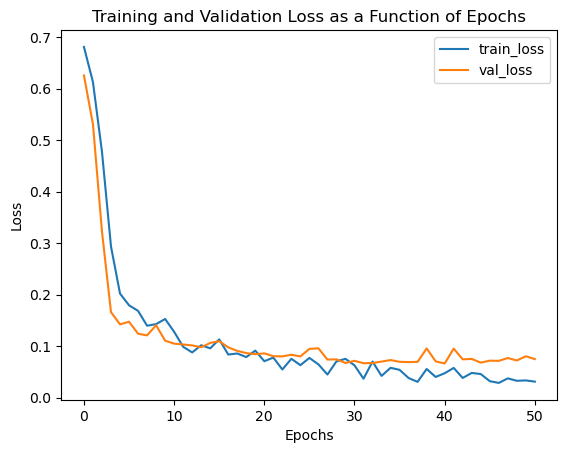

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss as a Function of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


/var/folders/v1/c8q_17915_v735dr_k_2fb7w0000gn/T/ipykernel_29910/4116439041.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"{title_prefix}\nTrue: {int(labels[idx])}, Pred: {int(predictions[idx])}")


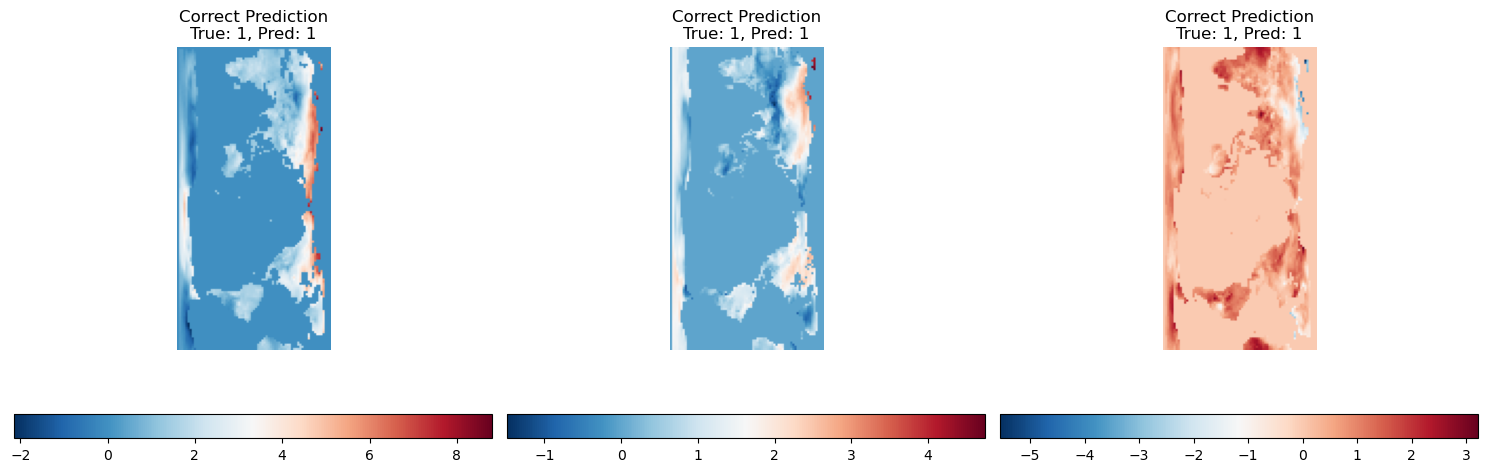

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def plot_climate_predictions(images, labels, predictions, correct=True):
    """
    images: the X data (test)
    labels: the Y data (test)
    predictions: the predictions 
    if correct set to True, function will look for correct predictions
    if correct set to False, function will look for incorrect preditions 
    """
    if correct:
        # finding indices where predictions are the same as Y data 
        idx_list = np.where(predictions == labels.flatten())[0]
        title_prefix = "Correct Prediction"
    else:
        # finding indices where predictions are not same as Y data
        idx_list = np.where(predictions != labels.flatten())[0]
        title_prefix = "Incorrect Prediction"

    # safety in case there are no correct or incorrect samples so code doesn't fail
    if len(idx_list) == 0:
        print(f"No samples found for {'correct' if correct else 'incorrect'} predictions.")
        return

    plt.figure(figsize=(15, 5))
    # looping at least 3 times through the index list where predictions are correct
    for i in range(min(3, len(idx_list))):
        # plot(s) with 1 row, 3 cols, then selects slot for current loop iteration 
        plt.subplot(1, 3, i+1)
        # picks random index in index list
            # aka random sample
        idx = np.random.choice(idx_list)
        
        # taking slice from x data that is the sample at the certain random index and then the lats and longs (getting rid of variable dimension)
        plt.imshow(images[idx, 0, :, :], cmap="RdBu_r") 
        plt.title(f"{title_prefix}\nTrue: {int(labels[idx])}, Pred: {int(predictions[idx])}")
        plt.colorbar(orientation='horizontal', pad=0.15)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# predicting in model using x test data 
raw_preds = model.predict(X_test)
# making preds into binary 
    # if pred is greater than 0.5 then given a 1
predictions = (raw_preds > 0.5).astype(int).flatten()


# running func 
plot_climate_predictions(X_test, y_test, predictions, correct=True)